## Telecom User Data Analysis

### Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from statistics import mean
from pandas_profiling import ProfileReport
import numpy as np
import json
import datetime
import math
import statsmodels.api as sm

from datetime import timedelta, datetime

import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

pd.options.mode.chained_assignment = None

import seaborn as sns


### Data Preprocessing

In [2]:
df = pd.read_csv("../data/telcom.csv")

In [3]:
df.head()

Bearer Id          Start  Start ms            End  End ms  Dur. (ms)  \
0  1.311450e+19   4/4/19 12:01     770.0  4/25/19 14:35   662.0  1823652.0   
1  1.311450e+19   4/9/19 13:04     235.0   4/25/19 8:15   606.0  1365104.0   
2  1.311450e+19   4/9/19 17:42       1.0  4/25/19 11:58   652.0  1361762.0   
3  1.311450e+19   4/10/19 0:31     486.0   4/25/19 7:36   171.0  1321509.0   
4  1.311450e+19  4/12/19 20:10     565.0  4/25/19 10:40   954.0  1089009.0   

           IMSI  MSISDN/Number          IMEI Last Location Name  ...  \
0  2.082014e+14   3.366496e+10  3.552121e+13        9.16457E+15  ...   
1  2.082019e+14   3.368185e+10  3.579401e+13            L77566A  ...   
2  2.082003e+14   3.376063e+10  3.528151e+13            D42335A  ...   
3  2.082014e+14   3.375034e+10  3.535661e+13            T21824A  ...   
4  2.082014e+14   3.369980e+10  3.540701e+13            D88865A  ...   

   Youtube DL (Bytes)  Youtube UL (Bytes)  Netflix DL (Bytes)  \
0          15854611.0           2501332.0           8198936.0   
1          20247395.0          19111729.0          18338413.0   
2          19725661.0          14699576.0          17587794.0   
3          21388122.0          15146643.0          13994646.0   
4          15259380.0          18962873.0          17124581.0   

   Netflix UL (Bytes)  Gaming DL (Bytes)  Gaming UL (Bytes)  Other DL (Bytes)  \
0           9656251.0        278082303.0         14344150.0       171744450.0   
1          17227132.0        608750074.0          1170709.0       526904238.0   
2           6163408.0        229584621.0           395630.0       410692588.0   
3           1097942.0        799538153.0         10849722.0       749039933.0   
4            415218.0        527707248.0          3529801.0       550709500.0   

   Other UL (Bytes)  Total UL (Bytes)  Total DL (Bytes)  
0         8814393.0        36749741.0       308879636.0  
1        15055145.0        53800391.0       653384965.0  
2         4215763.0        27883638.0       279807335.0  
3        12797283.0        43324218.0       846028530.0  
4        13910322.0        38542814.0       569138589.0  

[5 rows x 55 columns]

In [4]:
### Check for sufficiency of data to answer objectives by reviewing the objective and 
### available data. And check the number of observations and required sample size.

In [5]:
# generate pipelines
def generate_pipeline(type_="numeric",x=1):
    pipeline = None
    if type_ == "numeric":
        pipeline = Pipeline(steps=[
            ('impute', SimpleImputer(strategy='mean')),
            ('scale', MinMaxScaler())
        ])
    elif type_ == "categorical":
        pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
        ])
    else:
        pipeline = np.zeros(x)
    return pipeline



In [6]:
# test pipeline
numeric_pipeline = generate_pipeline("numeric")
assert isinstance(numeric_pipeline,Pipeline)

In [7]:
categorical_pipeline = generate_pipeline("categorical")
assert isinstance(numeric_pipeline,Pipeline)

In [8]:
def store_features(df,type_,value):
    features = [None]
    if type_ == "numeric":
        features = df.select_dtypes(include=value).columns.tolist()
    elif type_ == "categorical":
        features = df.select_dtypes(exclude=value).columns.tolist()
    return features


In [9]:
categorical_features = store_features(df,"categorical","number")

In [10]:
# testing function
numerical_features = store_features(df,"numeric","number")

In [11]:
len(numerical_features)

50

In [12]:
assert len(numerical_features)>0

In [13]:
### checking for duplicates

In [14]:
def generate_transformation(pipeline,df,type_,value):
    transformation = None
    if type_=="numeric":
        transformation=pipeline.fit_transform(df.select_dtypes(include=value))
    elif type_ == "categorical":
        transformation=pipeline.fit_transform(df.select_dtypes(exclude=value))
    return transformation

In [15]:
def frame_transforms(transform,features):
    return pd.DataFrame(transform,columns=features)

In [16]:
def handle_missing_values_numeric(df,features):
    """
    this algorithm does the following
    - remove columns with x percentage of missing values
    - fill the missing values with the mean
    returns:
        - df
        - percentage of missing values
    """
    missing_percentage = round((df.isnull().sum().sum()/\
            reduce(lambda x, y: x*y, df.shape))*100,2)
    for key in features:
        df[key] = df[key].fillna(df[key].mean())
    return missing_percentage, df

In [17]:
handle_missing_values_numeric(df,numerical_features)

(12.5,
            Bearer Id          Start  Start ms            End     End ms  \
 0       1.311450e+19   4/4/19 12:01  770.0000  4/25/19 14:35  662.00000   
 1       1.311450e+19   4/9/19 13:04  235.0000   4/25/19 8:15  606.00000   
 2       1.311450e+19   4/9/19 17:42    1.0000  4/25/19 11:58  652.00000   
 3       1.311450e+19   4/10/19 0:31  486.0000   4/25/19 7:36  171.00000   
 4       1.311450e+19  4/12/19 20:10  565.0000  4/25/19 10:40  954.00000   
 ...              ...            ...       ...            ...        ...   
 149996  7.277830e+18   4/29/19 7:28  451.0000   4/30/19 6:02  214.00000   
 149997  7.349880e+18   4/29/19 7:28  483.0000  4/30/19 10:41  187.00000   
 149998  1.311450e+19   4/29/19 7:28  283.0000  4/30/19 10:46  810.00000   
 149999  1.311450e+19   4/29/19 7:28  696.0000  4/30/19 10:40  327.00000   
 150000  1.013887e+19            NaN  499.1882            NaN  498.80088   
 
            Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
 0       1.

In [18]:
def handle_missing_values_categorical(df,features):
    """
    this algorithm does the following
    - remove columns with x percentage of missing values
    - fill the missing values with the mode
    returns:
        - df
        - percentage of missing values
    """
    missing_percentage = round((df.isnull().sum().sum()/\
            reduce(lambda x, y: x*y, df.shape))*100,2)
    for key in features:
        df[key] = df[key].fillna(df[key].mode()[0])
    return missing_percentage, df

In [19]:
handle_missing_values_categorical(df,categorical_features)

(0.03,
            Bearer Id          Start  Start ms            End     End ms  \
 0       1.311450e+19   4/4/19 12:01  770.0000  4/25/19 14:35  662.00000   
 1       1.311450e+19   4/9/19 13:04  235.0000   4/25/19 8:15  606.00000   
 2       1.311450e+19   4/9/19 17:42    1.0000  4/25/19 11:58  652.00000   
 3       1.311450e+19   4/10/19 0:31  486.0000   4/25/19 7:36  171.00000   
 4       1.311450e+19  4/12/19 20:10  565.0000  4/25/19 10:40  954.00000   
 ...              ...            ...       ...            ...        ...   
 149996  7.277830e+18   4/29/19 7:28  451.0000   4/30/19 6:02  214.00000   
 149997  7.349880e+18   4/29/19 7:28  483.0000  4/30/19 10:41  187.00000   
 149998  1.311450e+19   4/29/19 7:28  283.0000  4/30/19 10:46  810.00000   
 149999  1.311450e+19   4/29/19 7:28  696.0000  4/30/19 10:40  327.00000   
 150000  1.013887e+19   4/26/19 7:25  499.1882   4/25/19 0:01  498.80088   
 
            Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
 0       1.

In [20]:
# test transformations
numeric_transformation = generate_transformation(numeric_pipeline,df,"numeric","number")

In [21]:
numeric_df = frame_transforms(numeric_transformation,numerical_features)

In [76]:
categorical_df = df[categorical_features]

In [22]:
def split_data(df,response_variable,split_ratio,get):
    X = df.drop(response_variable, axis=1)
    y = df[response_variable]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_ratio, 
                                                    random_state=1121218)
    if get == "X_train":
        return X_train
    elif get == "X_test":
        return X_test
    elif get == "y_train":
        return y_train
    else:
        return y_test
    
    

In [23]:
numeric_transformation_ = generate_transformation(numeric_pipeline,
                                                 pd.DataFrame(split_data(df,"Total DL (Bytes)",0.3,"X_train")),
                                                 "numeric","number")

In [24]:
### Check for column organization and naming and correct them.

In [25]:
### Check for missing values and either fill them with a value that will, in no way, 
### affect the analysis or remove the record.

In [26]:
def top_x_column(df, x, column,color,online=False):
    handsets_df = pd.DataFrame(columns = [column])
    handsets_df['type'] = df[column].to_list()
    handsets = handsets_df['type'].value_counts()
    fig,ax = plt.subplots()
    ax.tick_params(axis='x',labelsize=10)
    ax.tick_params(axis='y',labelsize=10)
    ax.set_xlabel(column)
    ax.set_ylabel("Frequency")
    ax.set_title(f"The {x} Most Frequent {column}")
    handsets[:x].plot(ax=ax,kind='bar',color=color)
    handset_counts = handsets.to_dict()
    top_x = list(handset_counts.keys())
    if online:
        return fig,top_x[:x]
    else:
        return top_x[:x]
    

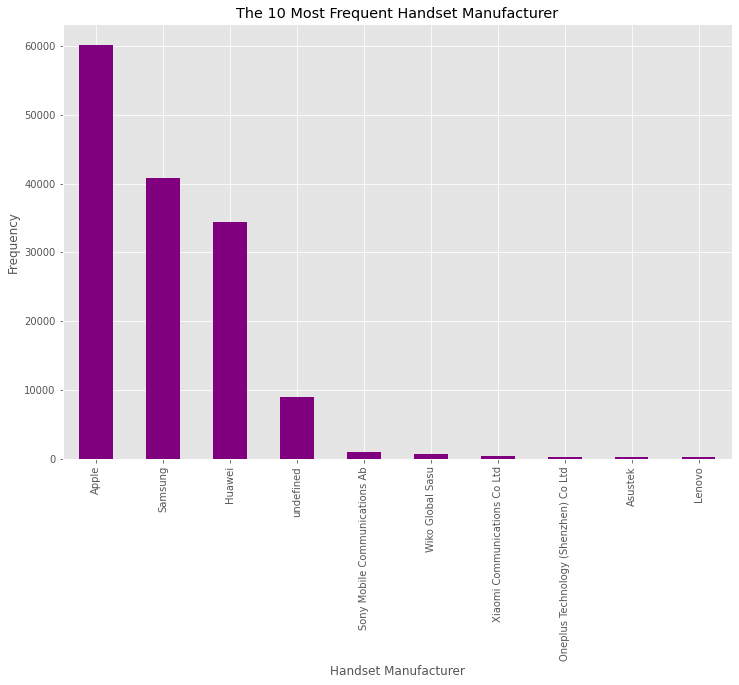

In [79]:
# identifying the top 10 handsets used by the customers.
values = top_x_column(df,10,"Handset Manufacturer","purple")

In [80]:
values

['Apple',
 'Samsung',
 'Huawei',
 'undefined',
 'Sony Mobile Communications Ab',
 'Wiko Global Sasu',
 'Xiaomi Communications Co Ltd',
 'Oneplus Technology (Shenzhen) Co Ltd',
 'Asustek',
 'Lenovo']

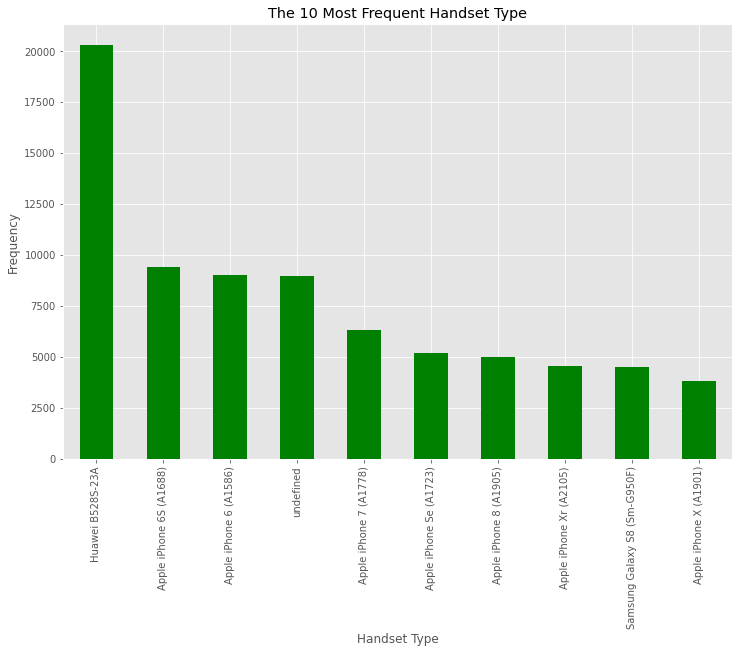

In [81]:
values = top_x_column(df,10,"Handset Type","green")

In [82]:
values

['Huawei B528S-23A',
 'Apple iPhone 6S (A1688)',
 'Apple iPhone 6 (A1586)',
 'undefined',
 'Apple iPhone 7 (A1778)',
 'Apple iPhone Se (A1723)',
 'Apple iPhone 8 (A1905)',
 'Apple iPhone Xr (A2105)',
 'Samsung Galaxy S8 (Sm-G950F)',
 'Apple iPhone X (A1901)']

In [30]:
# Identify the top 5 handsets per top 3 handset manufacturer
def top_x_by_y_cols(df,col_1,col_2,x,y):
    result_df = []
    by_manufacture = df.groupby(col_1,sort=True)
    values = top_x_column(df,x,col_1,"purple")


    for manufacturer, frame in by_manufacture:
        if manufacturer in values:
            result_df.append(frame.sort_values(by=[col_2], ascending=True)[col_2].head(5))
    return result_df
    

[40765     Apple iPad (A1823)
 131858    Apple iPad (A1823)
 50793     Apple iPad (A1823)
 114763    Apple iPad (A1823)
 123217    Apple iPad (A1823)
 Name: Handset Type, dtype: object,
 77840        Huawei Ale-Ul00
 17997        Huawei Ale-Ul00
 99869       Huawei Ascend G6
 99247       Huawei Ascend G6
 5655     Huawei Ascend G620S
 Name: Handset Type, dtype: object,
 10522    Samsung 2018 Galaxy J4
 91735    Samsung 2018 Galaxy J4
 95269    Samsung 2018 Galaxy J4
 80690    Samsung 2018 Galaxy J4
 10574    Samsung 2018 Galaxy J4
 Name: Handset Type, dtype: object]

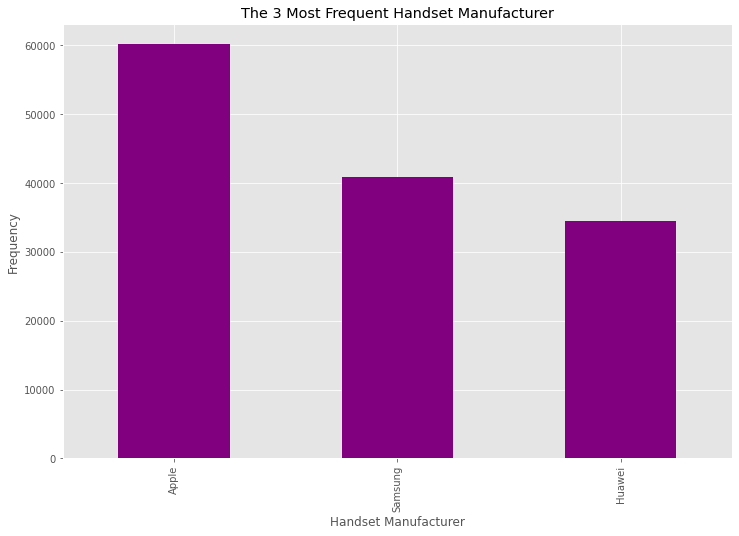

In [31]:
top_x_by_y_cols(df,'Handset Manufacturer','Handset Type',3,5)

In [32]:
# Aggregation per user the following information in the column  
# number of xDR sessions
# Session duration
# the total download (DL) and upload (UL) data
# the total data volume (in Bytes) during this session for each application


def aggregation_cols(df,col_1,col_2,trim=False):
    
    grouped = df.groupby(col_1).agg({col_2: [min, max, mean]}) 
    grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
    if trim:
        return grouped.describe()
    return grouped

In [33]:
aggregation_cols(df,'MSISDN/Number','Bearer Id',True)

Bearer Id_min  Bearer Id_max  Bearer Id_mean
count   1.068570e+05   1.068570e+05    1.068570e+05
mean    9.861426e+18   9.885904e+18    9.873743e+18
std     2.874549e+18   2.877143e+18    2.872758e+18
min     6.917540e+18   6.917540e+18    6.917540e+18
25%     7.277830e+18   7.349880e+18    7.313855e+18
50%     7.349880e+18   7.349880e+18    7.349880e+18
75%     1.304240e+19   1.311450e+19    1.307845e+19
max     1.318650e+19   1.318650e+19    1.318650e+19

In [83]:
9.873743e+18

9.873743e+18

In [34]:
aggregation_cols(df,'MSISDN/Number',"Dur. (ms)",True)

Dur. (ms)_min  Dur. (ms)_max  Dur. (ms)_mean
count   1.068570e+05   1.068570e+05    1.068570e+05
mean    9.670547e+04   1.092400e+05    1.026945e+05
std     6.860343e+04   8.303489e+04    7.224711e+04
min     7.142000e+03   7.142000e+03    7.142000e+03
25%     5.095100e+04   5.795400e+04    5.641000e+04
50%     8.639900e+04   8.640100e+04    8.640000e+04
75%     1.253680e+05   1.432080e+05    1.339120e+05
max     1.573420e+06   1.859336e+06    1.573420e+06

In [35]:
aggregation_cols(df,'MSISDN/Number','Total UL (Bytes)',True)

Total UL (Bytes)_min  Total UL (Bytes)_max  Total UL (Bytes)_mean
count          1.068570e+05          1.068570e+05           1.068570e+05
mean           3.906669e+07          4.318598e+07           4.112710e+07
std            1.126762e+07          1.126080e+07           1.038662e+07
min            2.866892e+06          2.866892e+06           2.866892e+06
25%            3.105584e+07          3.544137e+07           3.419707e+07
50%            3.878054e+07          4.351798e+07           4.112708e+07
75%            4.684224e+07          5.122037e+07           4.808013e+07
max            7.833131e+07          7.833131e+07           7.833131e+07

In [84]:
aggregation_cols(df,'MSISDN/Number','Total UL (Bytes)',True)['Total UL (Bytes)_mean']

count    1.068570e+05
mean     4.112710e+07
std      1.038662e+07
min      2.866892e+06
25%      3.419707e+07
50%      4.112708e+07
75%      4.808013e+07
max      7.833131e+07
Name: Total UL (Bytes)_mean, dtype: float64

In [36]:
aggregation_cols(df,'MSISDN/Number','Total DL (Bytes)',True)

Total DL (Bytes)_min  Total DL (Bytes)_max  Total DL (Bytes)_mean
count          1.068570e+05          1.068570e+05           1.068570e+05
mean           4.100965e+08          5.003926e+08           4.551845e+08
std            2.429135e+08          2.424866e+08           2.247896e+08
min            7.114041e+06          8.827082e+06           8.827082e+06
25%            1.956286e+08          2.990565e+08           2.762679e+08
50%            3.891644e+08          5.228791e+08           4.562471e+08
75%            6.119649e+08          7.137620e+08           6.338120e+08
max            9.029696e+08          9.029696e+08           9.029696e+08

In [85]:
aggregation_cols(df,'MSISDN/Number','Total DL (Bytes)',True)['Total DL (Bytes)_mean']

count    1.068570e+05
mean     4.551845e+08
std      2.247896e+08
min      8.827082e+06
25%      2.762679e+08
50%      4.562471e+08
75%      6.338120e+08
max      9.029696e+08
Name: Total DL (Bytes)_mean, dtype: float64

## EDA Analysis

In [37]:
#Describe all  relevant variables and associated data types
# Analyze the basic metrics (mean, median, etc) in the Dataset (explain) & 
# their importance for the global objective.
# Conduct a Non-Graphical Univariate Analysis by computing dispersion parameters 
# for each quantitative variable and provide useful interpretation.

def non_graphical_analysis(df,features,type_,opt,x_=1,y_=1):
    result = None
    if type_ == "univariate":
        for i,key in enumerate(features):
            if i == x_:
                result = pd.DataFrame(df[key].describe())
    elif type_ == "bivariate":
        for i,key in enumerate(features):
            if i == x_:
                if opt=="regression":
                    y = df[features[y_]]
                    x = df[[key]]
                    x = sm.add_constant(x)
                    model = sm.OLS(y, x).fit()
                    result =  model.summary()
                elif opt=="corr":
                    result = pd.DataFrame(df[[key,features[y_]]].corr())
    elif type_ == "multivariate":
        result = pd.DataFrame(df[features].corr())
    return result
        

In [38]:
non_graphical_analysis(numeric_df,numerical_features,"univariate",1)

Start ms
count  150001.000000
mean        0.499688
std         0.288900
min         0.000000
25%         0.250250
50%         0.499499
75%         0.749750
max         1.000000

In [39]:
non_graphical_analysis(numeric_df,numerical_features,"univariate",2)

Start ms
count  150001.000000
mean        0.499688
std         0.288900
min         0.000000
25%         0.250250
50%         0.499499
75%         0.749750
max         1.000000

In [40]:
non_graphical_analysis(numeric_df,numerical_features,"univariate",3)

Start ms
count  150001.000000
mean        0.499688
std         0.288900
min         0.000000
25%         0.250250
50%         0.499499
75%         0.749750
max         1.000000

In [41]:
non_graphical_analysis(numeric_df,numerical_features,"bivariate","regression",36,49)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Total DL (Bytes)   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     22.29
Date:                Wed, 11 May 2022   Prob (F-statistic):           2.35e-06
Time:                        14:07:35   Log-Likelihood:                -17825.
No. Observations:              150001   AIC:                         3.565e+04
Df Residuals:                  149999   BIC:                         3.567e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.4938      0.001    350.024      0.000       0.491       0.497
Google DL (Bytes)     0.0115      0.002      4.721      0.000       0.007       0.016
==============================================================================
Omnibus:                   131523.810   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8981.321
Skew:                          -0.003   Prob(JB):                         0.00
Kurtosis:                       1.801   Cond. No.                         4.40
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
non_graphical_analysis(numeric_df,numerical_features,"bivariate","corr",1,4)

Start ms      IMSI
Start ms  1.000000 -0.000054
IMSI     -0.000054  1.000000

In [43]:
# Conduct a Graphical Univariate Analysis by identifying the most suitable plotting options 
# for each variable and interpret your findings.

def graphical_analysis(df,features,type_,opt,x=1,y=1):
    result = None
    if type_ == "univariate":
        for i,key in enumerate(features):
            if i == x:
                if opt == 'box':
                    return df.boxplot(column=[key], grid=False, color='black')
                elif opt == 'hist':
                    return df.hist(column=[key], grid=False, edgecolor='black')
                elif opt == 'curve':
                    return sns.kdeplot(df[key])
    if type_ == "bivariate":
        for i,key in enumerate(features):
            if i == x:
                if opt == "scatter":
                    plt.scatter(df[features[x]], df[features[y]])
                    plt.title(f'{features[x]} vs {features[y]}')
                    plt.xlabel(f'{features[x]}')
                    plt.ylabel(f'{features[y]}')
                
    

array([[<AxesSubplot:title={'center':'Start ms'}>]], dtype=object)

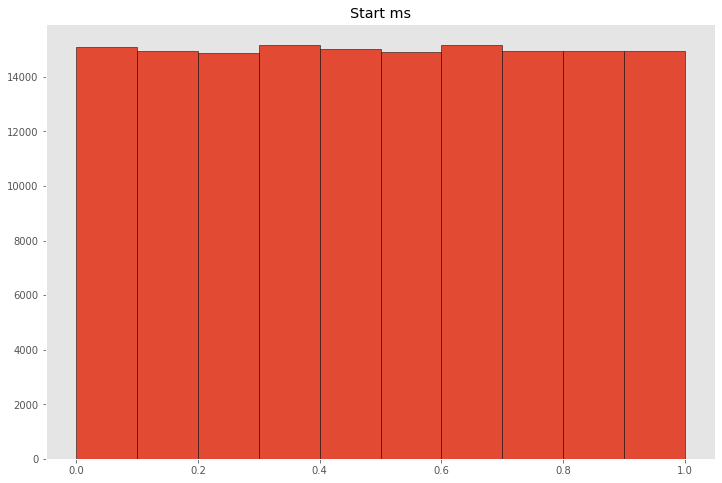

In [44]:
graphical_analysis(numeric_df,numerical_features,"univariate","hist",x=1)

In [45]:
graphical_analysis(numeric_df,numerical_features,"univariate","hist",x=2)

array([[<AxesSubplot:title={'center':'End ms'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'Dur. (ms)'}>]], dtype=object)

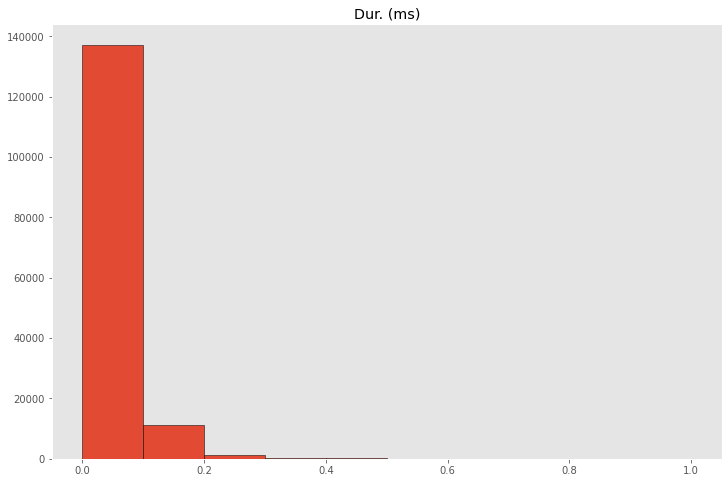

In [46]:
graphical_analysis(numeric_df,numerical_features,"univariate","hist",x=3)

In [47]:
graphical_analysis(numeric_df,numerical_features,"univariate","box",1)

<AxesSubplot:>

<AxesSubplot:>

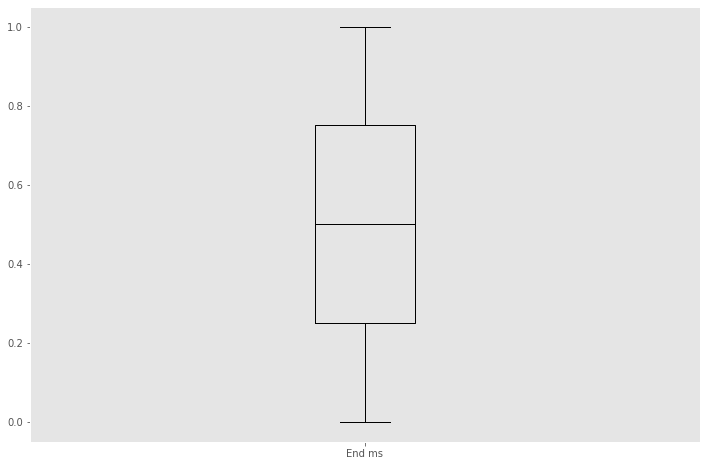

In [48]:
graphical_analysis(numeric_df,numerical_features,"univariate","box",x=2)

<AxesSubplot:>

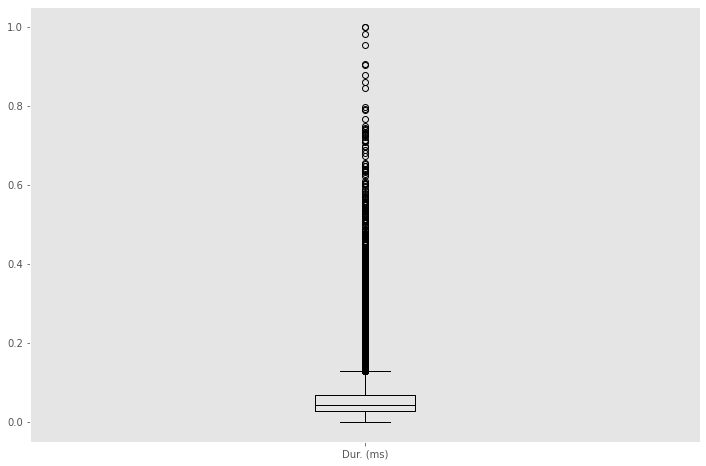

In [49]:
graphical_analysis(numeric_df,numerical_features,"univariate","box",x=3)

<AxesSubplot:>

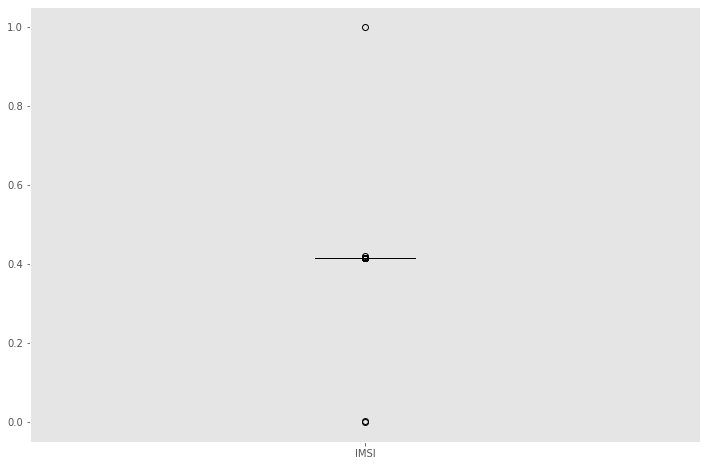

In [50]:
graphical_analysis(numeric_df,numerical_features,"univariate","box",x=4)

<AxesSubplot:xlabel='Start ms', ylabel='Density'>

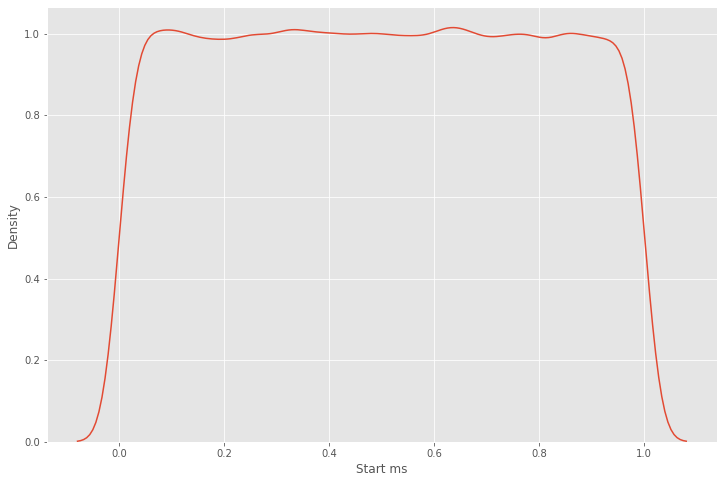

In [51]:
graphical_analysis(numeric_df,numerical_features,"univariate","curve",x=1)

<AxesSubplot:xlabel='End ms', ylabel='Density'>

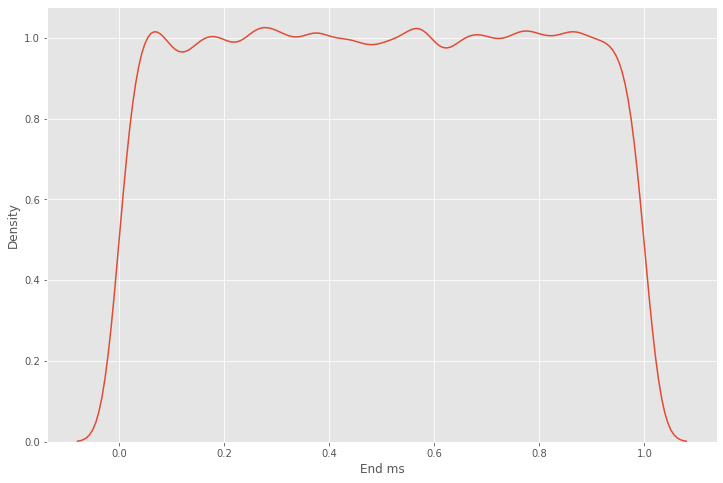

In [52]:
graphical_analysis(numeric_df,numerical_features,"univariate","curve",x=2)

<AxesSubplot:xlabel='Dur. (ms)', ylabel='Density'>

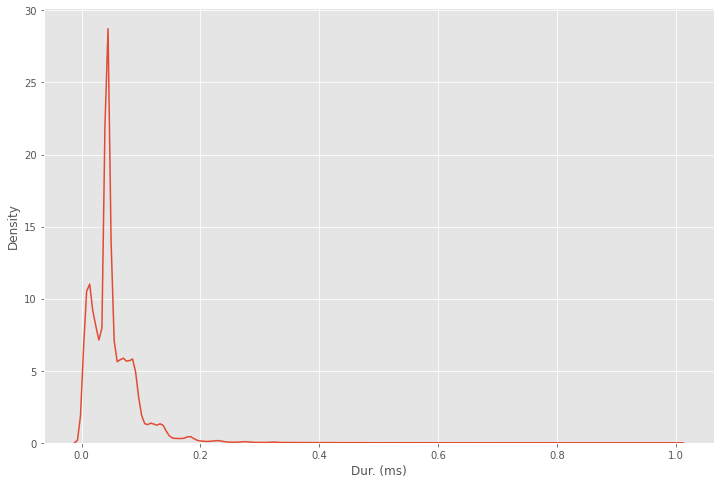

In [53]:
graphical_analysis(numeric_df,numerical_features,"univariate","curve",x=3)

<AxesSubplot:xlabel='IMSI', ylabel='Density'>

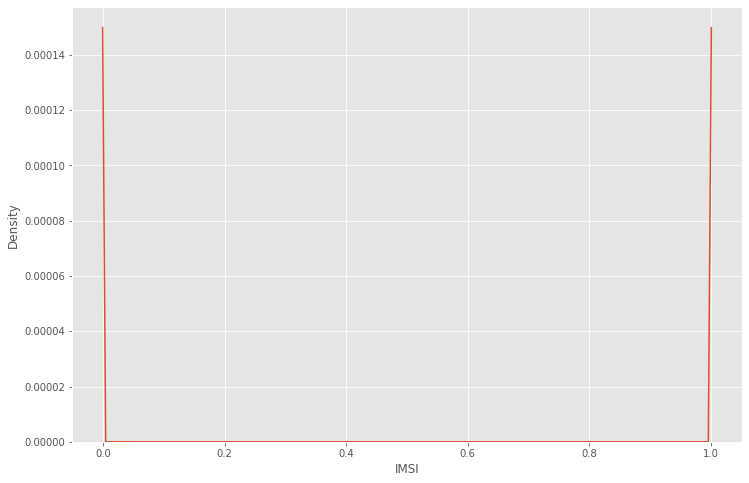

In [54]:
graphical_analysis(numeric_df,numerical_features,"univariate","curve",x=4)

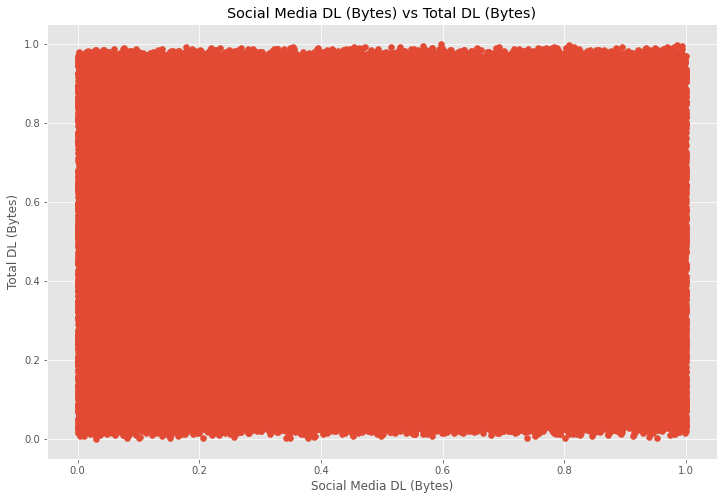

In [55]:
# Bivariate Analysis – explore the relationship between each application & 
# the total DL+UL data using appropriate methods and interpret your findings. 
graphical_analysis(numeric_df,numerical_features,"bivariate","scatter",x=34,y=49)

In [56]:
graphical_analysis(numeric_df,numerical_features,"bivariate","scatter",x=36,y=49)

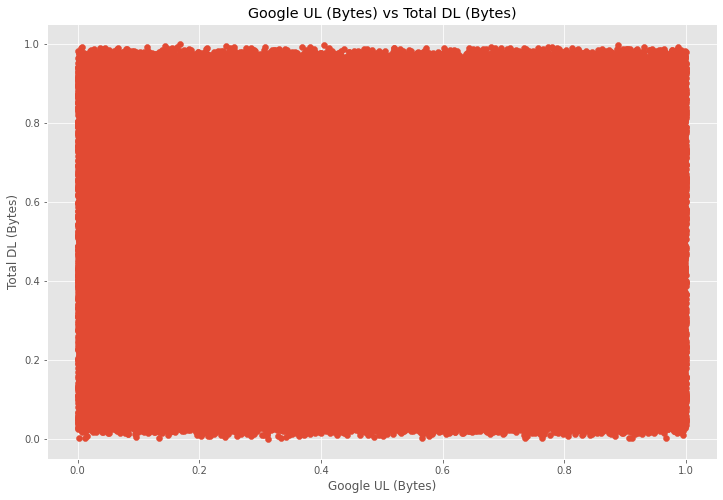

In [57]:
graphical_analysis(numeric_df,numerical_features,"bivariate","scatter",x=37,y=49)

In [58]:
# Correlation Analysis – compute a correlation matrix for the following variables and interpret your 
# findings: Social Media data, Google data, Email data, Youtube data, Netflix data, Gaming data, Other data 
non_graphical_analysis(numeric_df,numerical_features,"multivariate",1,4)

Bearer Id  Start ms    End ms  \
Bearer Id                                  1.000000  0.002951 -0.001215   
Start ms                                   0.002951  1.000000  0.120945   
End ms                                    -0.001215  0.120945  1.000000   
Dur. (ms)                                  0.007493  0.001287 -0.001302   
IMSI                                       0.000152 -0.000054  0.000328   
MSISDN/Number                             -0.003302 -0.001017 -0.001883   
IMEI                                       0.163837 -0.001130 -0.000032   
Avg RTT DL (ms)                           -0.019129  0.003740 -0.004769   
Avg RTT UL (ms)                            0.031439 -0.002006 -0.002352   
Avg Bearer TP DL (kbps)                    0.063856 -0.000690  0.000694   
Avg Bearer TP UL (kbps)                    0.047983 -0.001268  0.000687   
TCP DL Retrans. Vol (Bytes)                0.012301  0.000211  0.003182   
TCP UL Retrans. Vol (Bytes)                0.005243 -0.002142 -0.002017   
DL TP < 50 Kbps (%)                       -0.068979  0.000718 -0.003674   
50 Kbps < DL TP < 250 Kbps (%)             0.044024 -0.003099  0.004031   
250 Kbps < DL TP < 1 Mbps (%)              0.061944 -0.000160  0.002341   
DL TP > 1 Mbps (%)                         0.063012  0.002651  0.002754   
UL TP < 10 Kbps (%)                       -0.040872  0.000253 -0.001987   
10 Kbps < UL TP < 50 Kbps (%)              0.032147 -0.000157  0.002110   
50 Kbps < UL TP < 300 Kbps (%)             0.016807  0.000388  0.002517   
UL TP > 300 Kbps (%)                       0.010677  0.000124 -0.001943   
HTTP DL (Bytes)                            0.020248  0.002324  0.002180   
HTTP UL (Bytes)                            0.020819  0.001240 -0.001171   
Activity Duration DL (ms)                  0.081473 -0.000043  0.000404   
Activity Duration UL (ms)                  0.069137 -0.000338 -0.000790   
Dur. (ms).1                                0.007493  0.001287 -0.001302   
Nb of sec with 125000B < Vol DL            0.040469  0.004284  0.001326   
Nb of sec with 1250B < Vol UL < 6250B      0.020827 -0.000556  0.000493   
Nb of sec with 31250B < Vol DL < 125000B   0.053564  0.000488  0.001669   
Nb of sec with 37500B < Vol UL             0.004120 -0.000648 -0.003065   
Nb of sec with 6250B < Vol DL < 31250B     0.053442 -0.000902  0.004002   
Nb of sec with 6250B < Vol UL < 37500B     0.007840 -0.001799 -0.000323   
Nb of sec with Vol DL < 6250B              0.083021  0.000195 -0.004356   
Nb of sec with Vol UL < 1250B              0.076471  0.002214 -0.002281   
Social Media DL (Bytes)                   -0.000842  0.001262  0.003102   
Social Media UL (Bytes)                   -0.001121  0.000385 -0.004010   
Google DL (Bytes)                         -0.000691  0.002274 -0.001284   
Google UL (Bytes)                          0.002249  0.000722  0.004191   
Email DL (Bytes)                           0.002617  0.001144 -0.002262   
Email UL (Bytes)                          -0.000327 -0.001176 -0.000538   
Youtube DL (Bytes)                        -0.002458 -0.001582 -0.003741   
Youtube UL (Bytes)                        -0.000701  0.001238 -0.003450   
Netflix DL (Bytes)                        -0.000620 -0.002593  0.004132   
Netflix UL (Bytes)                        -0.003712 -0.002334 -0.001156   
Gaming DL (Bytes)                          0.000485 -0.004229 -0.004687   
Gaming UL (Bytes)                         -0.003201 -0.002512  0.000988   
Other DL (Bytes)                           0.000940 -0.003687  0.002758   
Other UL (Bytes)                          -0.002233  0.003803  0.002786   
Total UL (Bytes)                          -0.004562 -0.000028 -0.000574   
Total DL (Bytes)                           0.000399 -0.004299 -0.004687   

                                          Dur. (ms)      IMSI  MSISDN/Number  \
Bearer Id                                  0.007493  0.000152  -3.301523e-03   
Start ms                                   0.001287 -0.0

In [59]:
# pca analysis
def setup_pca(data,n):
    pca = PCA(n)
    x_ = pca.fit_transform(data)
    return x_, pca

In [60]:
def pca_analysis(df,features,no,x_,component):
    for i,key in enumerate(features):
        if i==x_:
            train = generate_transformation(numeric_pipeline,
                                         pd.DataFrame(split_data(df,key,0.3,"X_train")),
                                         "numeric","number")
            test = generate_transformation(numeric_pipeline,
                                             pd.DataFrame(split_data(df,key,0.3,"X_test")),
                                             "numeric","number")
            pca_train_results, pca_train = setup_pca(train, no)
            pca_test_results, pca_test = setup_pca(test, no)
            names_pcas = [f"PCA Component {i}" for i in range(1, 11, 1)]
            scree = pd.DataFrame(list(zip(names_pcas, pca_train.explained_variance_ratio_)), columns=["Component", "Explained Variance Ratio"])
            d = {'PCA':pca_train.components_[component], 'Variable Names':numerical_features[:x_]}
            df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))            
            df = df.sort_values('PCA', ascending=False)
            df2 = pd.DataFrame(df)
            df2['PCA']=df2['PCA'].apply(np.absolute)
            df2 = df2.sort_values('PCA', ascending=False)
            return df2
    return

In [61]:
pca_analysis(numeric_df,numerical_features,10,49,1)

PCA                            Variable Names
41  5.070779e-01                        Youtube UL (Bytes)
43  5.030060e-01                        Netflix UL (Bytes)
48  4.674381e-01                          Total UL (Bytes)
45  3.696105e-01                         Gaming UL (Bytes)
47  3.567867e-01                          Other UL (Bytes)
37  7.526006e-02                         Google UL (Bytes)
34  2.631418e-02                   Social Media DL (Bytes)
39  1.683063e-02                          Email UL (Bytes)
35  1.550450e-02                   Social Media UL (Bytes)
2   1.415498e-02                                    End ms
38  1.366299e-02                          Email DL (Bytes)
0   7.201439e-03                                 Bearer Id
1   6.480440e-03                                  Start ms
46  4.431236e-03                          Other DL (Bytes)
36  3.826623e-03                         Google DL (Bytes)
6   3.790212e-03                                      IMEI
44  3.594362e-03                         Gaming DL (Bytes)
40  3.127506e-03                        Youtube DL (Bytes)
42  2.896799e-03                        Netflix DL (Bytes)
13  2.041255e-03                       DL TP < 50 Kbps (%)
16  1.323236e-03                        DL TP > 1 Mbps (%)
9   7.905715e-04                   Avg Bearer TP DL (kbps)
23  6.841786e-04                 Activity Duration DL (ms)
18  6.195000e-04             10 Kbps < UL TP < 50 Kbps (%)
24  4.907900e-04                 Activity Duration UL (ms)
17  4.670984e-04                       UL TP < 10 Kbps (%)
33  4.580442e-04             Nb of sec with Vol UL < 1250B
10  4.308724e-04                   Avg Bearer TP UL (kbps)
15  3.857319e-04             250 Kbps < DL TP < 1 Mbps (%)
14  3.651767e-04            50 Kbps < DL TP < 250 Kbps (%)
11  3.637447e-04               TCP DL Retrans. Vol (Bytes)
32  3.328891e-04             Nb of sec with Vol DL < 6250B
26  2.954792e-04           Nb of sec with 125000B < Vol DL
3   2.681593e-04                                 Dur. (ms)
25  2.681590e-04                               Dur. (ms).1
30  2.492032e-04    Nb of sec with 6250B < Vol DL < 31250B
28  2.192182e-04  Nb of sec with 31250B < Vol DL < 125000B
20  1.355336e-04                      UL TP > 300 Kbps (%)
7   1.258770e-04                           Avg RTT DL (ms)
22  1.053643e-04                           HTTP UL (Bytes)
19  1.039892e-04            50 Kbps < UL TP < 300 Kbps (%)
31  9.906734e-05    Nb of sec with 6250B < Vol UL < 37500B
27  7.404232e-05     Nb of sec with 1250B < Vol UL < 6250B
8   7.104194e-05                           Avg RTT UL (ms)
5   6.403838e-05                             MSISDN/Number
29  5.206309e-05            Nb of sec with 37500B < Vol UL
12  3.727088e-05               TCP UL Retrans. Vol (Bytes)
4   5.542871e-06                                      IMSI
21  6.857078e-07                           HTTP DL (Bytes)

In [62]:
pca_analysis(numeric_df,numerical_features,10,48,1)

PCA                            Variable Names
44  0.727295                         Gaming DL (Bytes)
48  0.685707                                       NaN
40  0.016749                        Youtube DL (Bytes)
42  0.014915                        Netflix DL (Bytes)
1   0.010233                                  Start ms
36  0.007655                         Google DL (Bytes)
38  0.007041                          Email DL (Bytes)
46  0.006456                          Other DL (Bytes)
0   0.005349                                 Bearer Id
2   0.004969                                    End ms
34  0.004312                   Social Media DL (Bytes)
41  0.002613                        Youtube UL (Bytes)
39  0.001988                          Email UL (Bytes)
6   0.001476                                      IMEI
37  0.001371                         Google UL (Bytes)
47  0.001025                          Other UL (Bytes)
45  0.000984                         Gaming UL (Bytes)
35  0.000559                   Social Media UL (Bytes)
14  0.000341            50 Kbps < DL TP < 250 Kbps (%)
17  0.000216                       UL TP < 10 Kbps (%)
13  0.000214                       DL TP < 50 Kbps (%)
43  0.000180                        Netflix UL (Bytes)
10  0.000175                   Avg Bearer TP UL (kbps)
16  0.000173                        DL TP > 1 Mbps (%)
18  0.000163             10 Kbps < UL TP < 50 Kbps (%)
9   0.000156                   Avg Bearer TP DL (kbps)
8   0.000155                           Avg RTT UL (ms)
15  0.000133             250 Kbps < DL TP < 1 Mbps (%)
31  0.000115    Nb of sec with 6250B < Vol UL < 37500B
23  0.000102                 Activity Duration DL (ms)
19  0.000085            50 Kbps < UL TP < 300 Kbps (%)
21  0.000080                           HTTP DL (Bytes)
20  0.000079                      UL TP > 300 Kbps (%)
22  0.000076                           HTTP UL (Bytes)
11  0.000068               TCP DL Retrans. Vol (Bytes)
33  0.000066             Nb of sec with Vol UL < 1250B
27  0.000057     Nb of sec with 1250B < Vol UL < 6250B
7   0.000051                           Avg RTT DL (ms)
32  0.000042             Nb of sec with Vol DL < 6250B
12  0.000038               TCP UL Retrans. Vol (Bytes)
5   0.000034                             MSISDN/Number
29  0.000027            Nb of sec with 37500B < Vol UL
4   0.000027                                      IMSI
26  0.000024           Nb of sec with 125000B < Vol DL
3   0.000016                                 Dur. (ms)
25  0.000016                               Dur. (ms).1
30  0.000014    Nb of sec with 6250B < Vol DL < 31250B
28  0.000007  Nb of sec with 31250B < Vol DL < 125000B
24  0.000006                 Activity Duration UL (ms)

In [63]:
pca_analysis(numeric_df,numerical_features,10,47,1)

PCA                            Variable Names
44  0.727295                         Gaming DL (Bytes)
48  0.685707                                       NaN
40  0.016745                        Youtube DL (Bytes)
42  0.014913                        Netflix DL (Bytes)
1   0.010227                                  Start ms
36  0.007659                         Google DL (Bytes)
38  0.007054                          Email DL (Bytes)
46  0.006449                          Other DL (Bytes)
0   0.005352                                 Bearer Id
2   0.004962                                    End ms
34  0.004303                   Social Media DL (Bytes)
41  0.002923                        Youtube UL (Bytes)
39  0.001999                          Email UL (Bytes)
6   0.001476                                      IMEI
37  0.001315                         Google UL (Bytes)
47  0.000935                                       NaN
45  0.000746                         Gaming UL (Bytes)
35  0.000552                   Social Media UL (Bytes)
43  0.000495                        Netflix UL (Bytes)
14  0.000341            50 Kbps < DL TP < 250 Kbps (%)
17  0.000216                       UL TP < 10 Kbps (%)
13  0.000212                       DL TP < 50 Kbps (%)
10  0.000176                   Avg Bearer TP UL (kbps)
16  0.000174                        DL TP > 1 Mbps (%)
18  0.000164             10 Kbps < UL TP < 50 Kbps (%)
9   0.000156                   Avg Bearer TP DL (kbps)
8   0.000155                           Avg RTT UL (ms)
15  0.000133             250 Kbps < DL TP < 1 Mbps (%)
31  0.000115    Nb of sec with 6250B < Vol UL < 37500B
23  0.000102                 Activity Duration DL (ms)
19  0.000085            50 Kbps < UL TP < 300 Kbps (%)
21  0.000080                           HTTP DL (Bytes)
20  0.000079                      UL TP > 300 Kbps (%)
22  0.000076                           HTTP UL (Bytes)
11  0.000068               TCP DL Retrans. Vol (Bytes)
33  0.000066             Nb of sec with Vol UL < 1250B
27  0.000057     Nb of sec with 1250B < Vol UL < 6250B
7   0.000051                           Avg RTT DL (ms)
32  0.000042             Nb of sec with Vol DL < 6250B
12  0.000038               TCP UL Retrans. Vol (Bytes)
5   0.000034                             MSISDN/Number
29  0.000027            Nb of sec with 37500B < Vol UL
4   0.000027                                      IMSI
26  0.000024           Nb of sec with 125000B < Vol DL
3   0.000016                                 Dur. (ms)
25  0.000016                               Dur. (ms).1
30  0.000014    Nb of sec with 6250B < Vol DL < 31250B
28  0.000007  Nb of sec with 31250B < Vol DL < 125000B
24  0.000006                 Activity Duration UL (ms)

In [64]:
pca_analysis(numeric_df,numerical_features,10,34,1)

PCA                            Variable Names
43  0.727304                                       NaN
48  0.685707                                       NaN
39  0.016777                                       NaN
41  0.014937                                       NaN
1   0.010237                                  Start ms
35  0.007668                                       NaN
37  0.007023                                       NaN
45  0.006479                                       NaN
0   0.005328                                 Bearer Id
2   0.004993                                    End ms
40  0.003021                                       NaN
38  0.001994                                       NaN
6   0.001478                                      IMEI
36  0.001304                                       NaN
46  0.001303                                       NaN
47  0.001167                                       NaN
44  0.000682                                       NaN
42  0.000594                                       NaN
34  0.000553                                       NaN
14  0.000342            50 Kbps < DL TP < 250 Kbps (%)
17  0.000217                       UL TP < 10 Kbps (%)
13  0.000217                       DL TP < 50 Kbps (%)
10  0.000176                   Avg Bearer TP UL (kbps)
16  0.000173                        DL TP > 1 Mbps (%)
18  0.000165             10 Kbps < UL TP < 50 Kbps (%)
9   0.000156                   Avg Bearer TP DL (kbps)
8   0.000155                           Avg RTT UL (ms)
15  0.000135             250 Kbps < DL TP < 1 Mbps (%)
31  0.000115    Nb of sec with 6250B < Vol UL < 37500B
23  0.000103                 Activity Duration DL (ms)
19  0.000086            50 Kbps < UL TP < 300 Kbps (%)
21  0.000080                           HTTP DL (Bytes)
20  0.000079                      UL TP > 300 Kbps (%)
22  0.000076                           HTTP UL (Bytes)
11  0.000068               TCP DL Retrans. Vol (Bytes)
33  0.000066             Nb of sec with Vol UL < 1250B
27  0.000058     Nb of sec with 1250B < Vol UL < 6250B
7   0.000051                           Avg RTT DL (ms)
32  0.000042             Nb of sec with Vol DL < 6250B
12  0.000038               TCP UL Retrans. Vol (Bytes)
5   0.000034                             MSISDN/Number
29  0.000027            Nb of sec with 37500B < Vol UL
4   0.000027                                      IMSI
26  0.000024           Nb of sec with 125000B < Vol DL
3   0.000017                                 Dur. (ms)
25  0.000017                               Dur. (ms).1
30  0.000014    Nb of sec with 6250B < Vol DL < 31250B
28  0.000007  Nb of sec with 31250B < Vol DL < 125000B
24  0.000006                 Activity Duration UL (ms)

In [65]:
def categorize_based_on_deciles(df,features,x_):
    for i,key in enumerate(features):
        if i==x_:
            df['decile_rank'] = pd.qcut(df[key], 10,labels = False)
            return df.groupby(['decile_rank']).sum()
    return

In [66]:
categorize_based_on_deciles(numeric_df,numerical_features,39)

Bearer Id     Start ms       End ms   Dur. (ms)         IMSI  \
decile_rank                                                                   
0            7737.739116  7511.625626  7508.409409  790.734474  6215.348573   
1            7655.867999  7510.556557  7509.205205  792.463013  6214.926476   
2            7793.732020  7513.294294  7464.711712  780.773592  6214.913302   
3            7679.311722  7461.420420  7507.945946  793.148551  6215.331996   
4            7663.393995  7477.624625  7490.766767  793.549654  6215.067463   
5            7659.097051  7509.122311  7481.522323  791.373014  6215.335379   
6            7801.187391  7498.334334  7454.573574  782.669608  6214.523166   
7            7705.770003  7446.642643  7488.920921  799.927902  6214.511651   
8            7684.851184  7507.761762  7453.505506  784.976424  6214.499894   
9            7697.703338  7517.300300  7535.964965  783.769408  6214.910646   

             MSISDN/Number         IMEI  Avg RTT DL (ms)  Avg RTT UL (ms)  \
decile_rank                                                                 
0                 0.002217  7281.292190        17.018181        38.594787   
1                 0.002246  7324.700734        18.183441        36.435109   
2                 0.002233  7316.765236        17.154685        39.753168   
3                 0.384088  7287.468233        17.067026        36.124114   
4                 0.002441  7323.546267        17.263223        35.735102   
5                 0.002385  7260.927503        17.429296        36.627944   
6                 0.002056  7320.975546        16.703977        35.056422   
7                 0.005635  7355.358186        15.837671        36.482220   
8                 1.002282  7301.802465        16.053915        36.313639   
9                 0.002318  7331.275250        17.211780        40.991274   

             Avg Bearer TP DL (kbps)  ...  Youtube DL (Bytes)  \
decile_rank                           ...                       
0                         520.214169  ...         7557.838522   
1                         541.221298  ...         7479.121514   
2                         508.276957  ...         7485.922923   
3                         525.804300  ...         7490.852476   
4                         535.373540  ...         7508.716993   
5                         528.348657  ...         7499.358940   
6                         520.008621  ...         7479.462011   
7                         538.039787  ...         7520.615748   
8                         530.362437  ...         7481.172516   
9                         527.948366  ...         7526.440196   

             Youtube UL (Bytes)  Netflix DL (Bytes)  Netflix UL (Bytes)  \
decile_rank                                                               
0                   7553.050800         7475.050171         7482.164055   
1                   7506.958835         7496.484106         7463.389471   
2                   7524.425403         7500.566601         7500.022049   
3                   7537.001762         7493.440474         7539.359959   
4                   7495.846341         7512.591648         7518.432533   
5                   7534.811495         7485.748713         7521.712309   
6                   7495.786210         7552.301997         7472.321727   
7                   7495.838561         7525.838076         7478.030090   
8                   7456.813182         7493.074916         7473.087799   
9                   7422.977674         7447.579345         7523.085150   

             Gaming DL (Bytes)  Gaming UL (Bytes)  Other DL (Bytes)  \
decile_rank                                                           
0                  7501.721011        7452.043182       7558.012803   
1                  7540.067906        7532.281129       7524.411578   
2                  7541.869492        7495.065460       7485.674452   
3                  7486.482305        7472.024167       7450.728099   
4                  7505.345177   

In [67]:
categorize_based_on_deciles(numeric_df,numerical_features,49)

Bearer Id     Start ms       End ms   Dur. (ms)         IMSI  \
decile_rank                                                                   
0            7675.942677  7548.282282  7564.865866  782.278670  6214.921436   
1            7700.971034  7519.969970  7527.629630  791.841621  6214.472766   
2            7697.836620  7511.341341  7434.544545  794.128592  6214.909781   
3            7789.028174  7509.410410  7461.700701  794.050711  6214.902990   
4            7680.613785  7452.625814  7556.994796  782.575854  6214.926603   
5            7680.786287  7492.820821  7475.898899  795.322289  6214.935901   
6            7715.025022  7483.936937  7437.067067  785.108747  6214.932810   
7            7738.158130  7481.901902  7531.794795  786.498794  6215.512521   
8            7690.079556  7507.555556  7456.246246  793.568808  6214.924821   
9            7710.212534  7445.837838  7448.783784  788.011552  6214.928918   

             MSISDN/Number         IMEI  Avg RTT DL (ms)  Avg RTT UL (ms)  \
decile_rank                                                                 
0                 1.002161  7347.667053        17.005321        34.847943   
1                 0.005881  7263.472542        18.095242        36.316818   
2                 0.002241  7279.594324        16.566661        37.398549   
3                 0.002204  7306.978491        16.974832        39.675610   
4                 0.002365  7332.716727        18.050421        36.446108   
5                 0.002206  7322.886099        16.589352        36.777866   
6                 0.384097  7312.481869        16.456047        36.366126   
7                 0.002235  7298.446839        17.003158        41.158802   
8                 0.002228  7295.193096        16.770091        36.056625   
9                 0.002283  7344.674570        16.412068        37.069330   

             Avg Bearer TP DL (kbps)  ...  Youtube DL (Bytes)  \
decile_rank                           ...                       
0                         543.665414  ...         7158.562653   
1                         522.466229  ...         7510.037484   
2                         513.791802  ...         7509.714897   
3                         535.975233  ...         7536.642119   
4                         530.408222  ...         7542.235157   
5                         529.501962  ...         7436.433973   
6                         513.674521  ...         7514.556850   
7                         524.591342  ...         7469.191889   
8                         524.472467  ...         7501.684173   
9                         537.050939  ...         7850.442644   

             Youtube UL (Bytes)  Netflix DL (Bytes)  Netflix UL (Bytes)  \
decile_rank                                                               
0                   7561.751955         7168.285280         7502.264940   
1                   7494.976829         7543.916906         7511.251872   
2                   7510.731679         7528.236218         7492.695005   
3                   7494.374229         7507.141641         7505.909868   
4                   7511.960324         7506.767045         7504.494912   
5                   7543.222394         7463.511125         7467.554413   
6                   7413.981420         7439.377909         7488.675892   
7                   7441.097801         7498.768010         7500.459638   
8                   7536.140318         7443.736741         7501.107058   
9                   7515.273314         7882.935172         7497.191544   

             Gaming DL (Bytes)  Gaming UL (Bytes)  Other DL (Bytes)  \
decile_rank                                                           
0                   754.203969        7520.623485       7511.374488   
1                  2233.086587        7533.802386       7510.316362   
2                  3741.135573        7523.075273       7436.265413   
3                  5252.409702        7446.530464       7501.405858   
4                  6766.238562   

In [68]:
categorize_based_on_deciles(numeric_df,numerical_features,34)

Bearer Id     Start ms       End ms   Dur. (ms)         IMSI  \
decile_rank                                                                   
0            7686.436630  7529.936937  7461.229229  792.488442  6215.338208   
1            7685.915054  7478.748749  7512.865866  795.788967  6214.508842   
2            7730.294471  7510.716717  7442.536537  786.324001  6214.914024   
3            7768.196416  7437.657658  7441.740741  789.837940  6214.912712   
4            7794.869107  7474.259259  7479.313313  796.695713  6214.488736   
5            7677.644060  7478.385574  7515.357158  778.130540  6214.910098   
6            7667.492205  7478.935936  7515.350350  793.371604  6215.506637   
7            7607.766090  7573.249249  7552.944945  784.008718  6214.924672   
8            7671.499609  7474.620621  7489.039039  786.866177  6214.949605   
9            7788.540176  7517.172172  7485.149149  789.873537  6214.915012   

             MSISDN/Number         IMEI  Avg RTT DL (ms)  Avg RTT UL (ms)  \
decile_rank                                                                 
0                 0.002287  7296.637126        16.852222        36.566157   
1                 0.387646  7344.326772        15.834275        38.545639   
2                 0.002194  7305.732906        17.304032        36.882842   
3                 0.002052  7301.176536        17.177738        37.948672   
4                 1.002280  7275.266368        18.333737        34.498801   
5                 0.002302  7310.846815        16.542118        36.154192   
6                 0.002380  7342.036432        17.373692        38.865065   
7                 0.002273  7280.335733        16.623271        38.723759   
8                 0.002238  7346.253630        18.099884        36.532000   
9                 0.002250  7301.499290        15.782224        37.396651   

             Avg Bearer TP DL (kbps)  ...  Youtube DL (Bytes)  \
decile_rank                           ...                       
0                         525.702777  ...         7507.920025   
1                         541.871123  ...         7508.094599   
2                         522.190813  ...         7538.236309   
3                         518.998133  ...         7541.242945   
4                         524.374154  ...         7480.392072   
5                         539.972237  ...         7485.976693   
6                         536.173035  ...         7443.724549   
7                         523.651341  ...         7480.651360   
8                         523.187249  ...         7492.505887   
9                         519.477269  ...         7550.757401   

             Youtube UL (Bytes)  Netflix DL (Bytes)  Netflix UL (Bytes)  \
decile_rank                                                               
0                   7478.449280         7517.356069         7452.228057   
1                   7472.710924         7454.667001         7430.489312   
2                   7487.066291         7525.987453         7497.790305   
3                   7459.079804         7517.311017         7513.094223   
4                   7570.875502         7504.934259         7554.298275   
5                   7541.798956         7520.538717         7538.194961   
6                   7518.936656         7522.408818         7501.652993   
7                   7493.688887         7438.652797         7473.137246   
8                   7470.818510         7511.700824         7509.222986   
9                   7530.085451         7469.119093         7501.496784   

             Gaming DL (Bytes)  Gaming UL (Bytes)  Other DL (Bytes)  \
decile_rank                                                           
0                  7548.760029        7489.799941       7463.884948   
1                  7487.432800        7555.771009       7457.962743   
2                  7464.480139        7449.846394       7446.703490   
3                  7513.803709        7459.046482       7489.607601   
4                  7463.882472   

In [69]:
def fixing_outliers(df, column):
    df[column] = np.where(df[column] > df[column].quantile(0.95), 
                          df[column].median(),df[column])
    
    return df[column]


In [72]:
numeric_df["Dur. (ms)"] = fixing_outliers(numeric_df, "Dur. (ms)")

In [73]:
graphical_analysis(numeric_df,numerical_features,"univariate","box",x=3)

<AxesSubplot:>